# CARTaGENE Saguenay–Lac-Saint-Jean

The goal of this Jupyter notebook is to compare realised (genotype) kinship with expected (genealogical) kinship in the Saguenay–Lac-Saint-Jean cluster, and visualise its population structure.

In [1]:
from collections import Counter
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
from skbio.stats.ordination import pcoa
from sklearn.covariance import EllipticEnvelope
import umap

The paths to the datasets are found in the *paths.json* file.

In [2]:
with open("../paths.json", 'r') as file:
    paths = json.load(file)

The following DataFrame associates each CARTaGENE ID to a BALSAC ID.

In [3]:
with open(paths['cartagene_balsac_matches'], 'r') as file:
    association_df = pd.read_csv(file, sep=' ')

The following dictionary uses the associations to convert any CARTaGENE ID to its corresponding BALSAC ID.

In [4]:
cag_to_balsac = dict()
for index, (balsac, cartagene) in association_df.iterrows():
    cag_to_balsac[f'{cartagene}_{cartagene}'] = int(balsac)

Let's load the realised (genotype) kinship that was previously computed at step 2.

In [5]:
ibd_matrix = pd.read_csv(paths['wd'] + "results/realised_kinship", index_col=0, sep='\t')

The following converts the CARTaGENE IDs from the realised kinship matrix to BALSAC IDs and extracts the individuals who have both genotype and genealogical data in the CARTaGENE cohort.

In [6]:
codes = [code for code in sorted(ibd_matrix.index) if code in cag_to_balsac.keys()]
ibd_matrix = ibd_matrix.loc[codes, codes]
inds = [cag_to_balsac[code] for code in codes]
ibd_matrix.index = inds
ibd_matrix.columns = inds
ibd_matrix.sort_index(axis=0, inplace=True)
ibd_matrix.sort_index(axis=1, inplace=True)
inds = sorted(inds)

Let's load the individuals from the Saguenay–Lac-Saint-Jean cluster.

In [7]:
with open(paths['wd'] + "results/pickles/cartagene_inds_slsj.pkl", 'rb') as file:
    inds = pickle.load(file)
len(inds)

938

Isolate the kinship of those individuals and replace the diagonal with ones.

In [8]:
ibd_matrix = ibd_matrix.loc[inds, inds]
np.fill_diagonal(ibd_matrix.values, 1.0)

Do the same with the expected (genealogical) kinship.

In [9]:
with open(paths['wd'] + "results/pickles/cartagene_expected_kinship.pkl", 'rb') as file:
    phi_matrix = pickle.load(file)
phi_matrix = phi_matrix.loc[inds, inds]
np.fill_diagonal(phi_matrix.values, 1.0)

Compute the UMAP projection for the realised kinship.

In [10]:
pcoa_genes_slsj = pcoa(
    1 - ibd_matrix,
    method='eigh',
    seed=0
)

In [11]:
umap_genes_slsj = umap.UMAP(
    min_dist=0.5,
    n_neighbors=15,
    metric='precomputed',
    random_state=0,
    init=pcoa_genes_slsj.samples.values[:, :2],
).fit_transform(
    1-ibd_matrix
)

Do the same with the expected kinship.

In [12]:
pcoa_genealogy_slsj = pcoa(
    1 - phi_matrix,
    method='eigh',
    seed=0
)

In [13]:
umap_genealogy_slsj = umap.UMAP(
    min_dist=0.5,
    n_neighbors=15,
    metric='precomputed',
    random_state=0,
    init=pcoa_genealogy_slsj.samples.values[:, :2],
).fit_transform(
    1-phi_matrix
)

Compute the linear regression to compare both kinship matrices.

In [14]:
x = ibd_matrix.values[np.triu_indices_from(ibd_matrix, k=1)]
y = phi_matrix.values[np.triu_indices_from(phi_matrix, k=1)]
result = linregress(x, y)
(result.slope, result.intercept, result.rvalue, result.pvalue)

(0.7188334530116087, 0.0015469511955682, 0.8263185788004478, 0.0)

Now, let's load the demographical information about the individuals' marriages.

In [15]:
with open(paths['demography_information'], 'rb') as file:
    civil_df = pd.read_csv(file, sep=';', low_memory=False)

The following extracts the municipality codes of the parents' location of marriage.

In [16]:
cities_parents = civil_df.set_index('IndID').loc[inds].loc[:, 'URBMariageParents'].tolist()
cities_parents = [0 if np.isnan(city) else int(city) for city in cities_parents]
cities_parents[:10]

[2780, 2780, 2780, 2780, 2780, 2780, 2860, 2860, 2860, 2860]

The following converts the municipality codes to regions.

In [17]:
with open(paths['geography_definitions']) as file:
    definition_df = pd.read_csv(file)
cities_parents_df = pd.DataFrame({'UrbIdMariage': cities_parents})
unknown_row = pd.DataFrame({'UrbIdMariage': [0], 'UrbMariage': ['Inconnue']})
definition_df = pd.concat([definition_df, unknown_row], ignore_index=True)
result = cities_parents_df.merge(definition_df[['UrbIdMariage', 'UrbMariage']], on='UrbIdMariage', how='left').fillna('Unknown')
city_marriage_list = result['UrbMariage'].tolist()
len(city_marriage_list)

938

The following dictionary associates a watercourse subdivision to each municipality.

In [18]:
city_to_water_boundary = {
    "Albanel": "Ashuapmushuan-Mistassini",
    "Alma": "East of Lac Saint-Jean",
    "Arvida": "South of Saguenay River",
    "Bégin": "North of Saguenay River",
    "Chambord": "Métabetchouane-Ashuapmushuan",
    "Chicoutimi": "South of Saguenay River",
    "Chicoutimi-Nord": "North of Saguenay River",
    "Chute-des-Passes": "Mistassini-Péribonka",
    "Delisle": "East of Lac Saint-Jean",
    "Desbiens": "La-Belle-Rivière–Métabetchouane",
    "Dolbeau": "Ashuapmushuan-Mistassini",
    "Ferland-et-Boilleau": "South of Saguenay River",
    "Girardville": "Ashuapmushuan-Mistassini",
    "Hébertville": "East of Lac Saint-Jean",
    "Hébertville-Station": "East of Lac Saint-Jean",
    "Jonquière": "South of Saguenay River",
    "L'Anse-Saint-Jean": "East of Ha! Ha!",
    "L'Ascension-de-Notre-Seigneur": "East of Lac Saint-Jean",
    "La Baie": "South of Saguenay River",
    "La Doré": "Métabetchouane-Ashuapmushuan",
    "Labrecque": "East of Lac Saint-Jean",
    "Lac-Bouchette": "Métabetchouane-Ashuapmushuan",
    "Lac-Kénogami": "South of Saguenay River",
    "Lac-à-la-Croix": "La-Belle-Rivière–Métabetchouane",
    "Larouche": "South of Saguenay River",
    "Laterrière": "South of Saguenay River",
    "Mashteuiatsh": "Métabetchouane-Ashuapmushuan",
    "Mistassini": "Mistassini-Péribonka",
    "Métabetchouan": "La-Belle-Rivière–Métabetchouane",
    "Mont-Apica": "East of Lac Saint-Jean",
    "Normandin": "Ashuapmushuan-Mistassini",
    "Notre-Dame-de-Lorette": "Mistassini-Péribonka",
    "Notre-Dame-du-Rosaire": "East of Lac Saint-Jean",
    "Petit-Saguenay": "East of Ha! Ha!",
    "Péribonka": "Mistassini-Péribonka",
    "Rivière-Éternité": "East of Ha! Ha!",
    "Roberval": "Métabetchouane-Ashuapmushuan",
    "Saint-Ambroise": "North of Saguenay River",
    "Saint-André-du-Lac-Saint-Jean": "La-Belle-Rivière–Métabetchouane",
    "Saint-Augustin-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Bruno": "East of Lac Saint-Jean",
    "Saint-Charles-de-Bourget": "North of Saguenay River",
    "Saint-David-de-Falardeau": "North of Saguenay River",
    "Saint-Edmond": "Ashuapmushuan-Mistassini",
    "Saint-Eugène-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-François-de-Sales": "Métabetchouane-Ashuapmushuan",
    "Saint-Fulgence": "North of Saguenay River",
    "Saint-Félicien": "Métabetchouane-Ashuapmushuan",
    "Saint-Félix-d'Otis": "East of Ha! Ha!",
    "Saint-Gédéon": "East of Lac Saint-Jean",
    "Saint-Henri-de-Taillon": "East of Lac Saint-Jean",
    "Saint-Honoré-de-Chicoutimi": "North of Saguenay River",
    "Saint-Ludger-de-Milot": "Mistassini-Péribonka",
    "Saint-Méthode": "Ashuapmushuan-Mistassini",
    "Saint-Nazaire": "East of Lac Saint-Jean",
    "Saint-Prime": "Métabetchouane-Ashuapmushuan",
    "Saint-Stanislas-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Saint-Thomas-Didyme": "Ashuapmushuan-Mistassini",
    "Sainte-Hedwidge": "Métabetchouane-Ashuapmushuan",
    "Sainte-Jeanne-d'Arc-du-Lac-Saint-Jean": "Mistassini-Péribonka",
    "Sainte-Monique-de-Honfleur": "East of Lac Saint-Jean",
    "Sainte-Rose-du-Nord": "North of Saguenay River",
    "Sainte-Élisabeth-de-Proulx": "Mistassini-Péribonka",
    "Shipshaw": "North of Saguenay River",
    "Val-Jalbert": "Métabetchouane-Ashuapmushuan",
    'Baie-Sainte-Catherine': 'Charlevoix',
    'Baie-Saint-Paul': 'Charlevoix',
    "Cap A L'aigle": 'Charlevoix',
    'Clermont': 'Charlevoix',
    'La Malbaie': 'Charlevoix',
    'Les Éboulements': 'Charlevoix',
    'Notre Dame Des Monts': 'Charlevoix',
    'Petite-Rivière-Saint-François': 'Charlevoix',
    'Pointe-au-Pic': 'Charlevoix',
    'St Aime Des Lacs': 'Charlevoix',
    "Saint-Bernard-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Sainte-Agnès': 'Charlevoix',
    'Saint-Fidèle-de-Mont-Murray': 'Charlevoix',
    'Saint-Hilarion': 'Charlevoix',
    'Saint-Irénée': 'Charlevoix',
    'Saint-Joseph-de-la-Rive': 'Charlevoix',
    "Saint-Louis-de-l'Isle-aux-Coudres": 'Charlevoix',
    'Saint-Siméon': 'Charlevoix',
    'Saint-Urbain-de-Charlevoix': 'Charlevoix'
}

Let's identify the watercourse subdivision of each proband.

In [19]:
boundaries_parents = [city_to_water_boundary.get(city, 'Outside Charlevoix/SLSJ or unknown') for city in city_marriage_list]
boundaries_counts = Counter(boundaries_parents)
boundaries_counts

Counter({'Outside Charlevoix/SLSJ or unknown': 323,
         'South of Saguenay River': 277,
         'East of Lac Saint-Jean': 90,
         'North of Saguenay River': 72,
         'Charlevoix': 49,
         'Métabetchouane-Ashuapmushuan': 48,
         'Ashuapmushuan-Mistassini': 23,
         'Mistassini-Péribonka': 20,
         'La-Belle-Rivière–Métabetchouane': 20,
         'East of Ha! Ha!': 16})

Associate a colour to each watercourse subdivision.

In [20]:
subdivision_to_colour = {
    "Charlevoix": 'orangered',
    "East of Ha! Ha!": 'gold',
    "South of Saguenay River": 'lime',
    "East of Lac Saint-Jean": 'darkgreen',
    "La-Belle-Rivière–Métabetchouane": 'aqua',
    "Métabetchouane-Ashuapmushuan": 'dodgerblue',
    "Ashuapmushuan-Mistassini": '#a020f0',
    "Mistassini-Péribonka": 'rosybrown',
    "North of Saguenay River": 'deeppink',
    "Outside Charlevoix/SLSJ or unknown": 'gainsboro'
}
boundaries_colours = [subdivision_to_colour[boundaries] for boundaries in boundaries_parents]
boundaries_colours[:10]

['deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink',
 'deeppink']

Plot figure 3 of the article.

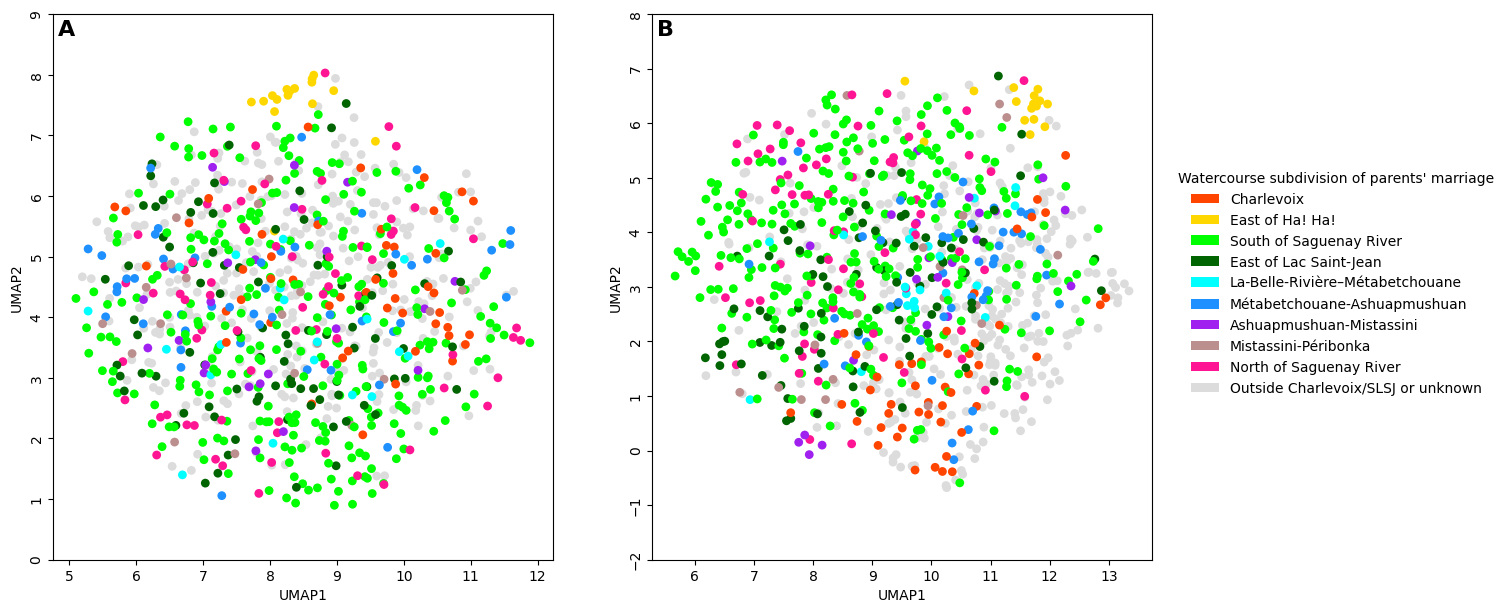

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(180*2/25.4, 90*2/25.4))

in_slsj = [ind in inds for ind in ibd_matrix.columns]

gray = [index for index, boundary in enumerate(boundaries_parents)
        if boundary == 'Outside Charlevoix/SLSJ or unknown']
filter = [index for index, boundary in enumerate(boundaries_parents)
          if boundary != 'Outside Charlevoix/SLSJ or unknown']

sp = sns.scatterplot(
    x=umap_genes_slsj[:, 0][in_slsj][gray],
    y=umap_genes_slsj[:, 1][in_slsj][gray],
    hue=[boundaries_parents[index] for index in gray],
    palette=subdivision_to_colour,
    edgecolor='none',
    s=40,
    ax=ax[0])
sp = sns.scatterplot(
    x=umap_genes_slsj[:, 0][in_slsj][filter],
    y=umap_genes_slsj[:, 1][in_slsj][filter],
    hue=[boundaries_parents[index] for index in filter],
    palette=subdivision_to_colour,
    edgecolor='none',
    s=40,
    ax=ax[0])
sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Rotate the y axis labels
yticks = sp.get_yticks()
yticklabels = sp.get_yticklabels()
sp.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Disable legend
sp.get_legend().remove()

# Add label "A)" in bold to top-left
ax[0].text(0.01, 0.99, "A", transform=ax[0].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

sp = sns.scatterplot(
    x=umap_genealogy_slsj[:, 0][in_slsj][gray],
    y=umap_genealogy_slsj[:, 1][in_slsj][gray],
    hue=[boundaries_parents[index] for index in gray],
    palette=subdivision_to_colour,
    edgecolor='none',
    s=40,
    ax=ax[1])
sp = sns.scatterplot(
    x=umap_genealogy_slsj[:, 0][in_slsj][filter],
    y=umap_genealogy_slsj[:, 1][in_slsj][filter],
    hue=[boundaries_parents[index] for index in filter],
    palette=subdivision_to_colour,
    edgecolor='none',
    s=40,
    ax=ax[1])
sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Rotate the y axis labels
yticks = sp.get_yticks()
yticklabels = sp.get_yticklabels()
sp.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Disable legend
sp.get_legend().remove()

# Add label "B)" in bold to top-left
ax[1].text(0.01, 0.99, "B", transform=ax[1].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=water_boundary)
                   for water_boundary, color in subdivision_to_colour.items()]

# Legend outside the plot
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(0.91, 0.5),
                           loc='center left', frameon=False)

legend_handle.set_title("Watercourse subdivision of parents' marriage")

fig.savefig(paths['wd'] + "results/figures/3.CARTaGENESLSJ.svg", bbox_inches='tight')
plt.show()

The following function, used to plot confidence ellipses over the UMAP projection, comes from [this webpage](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html).

In [22]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Plot Supplementary Figure 3.

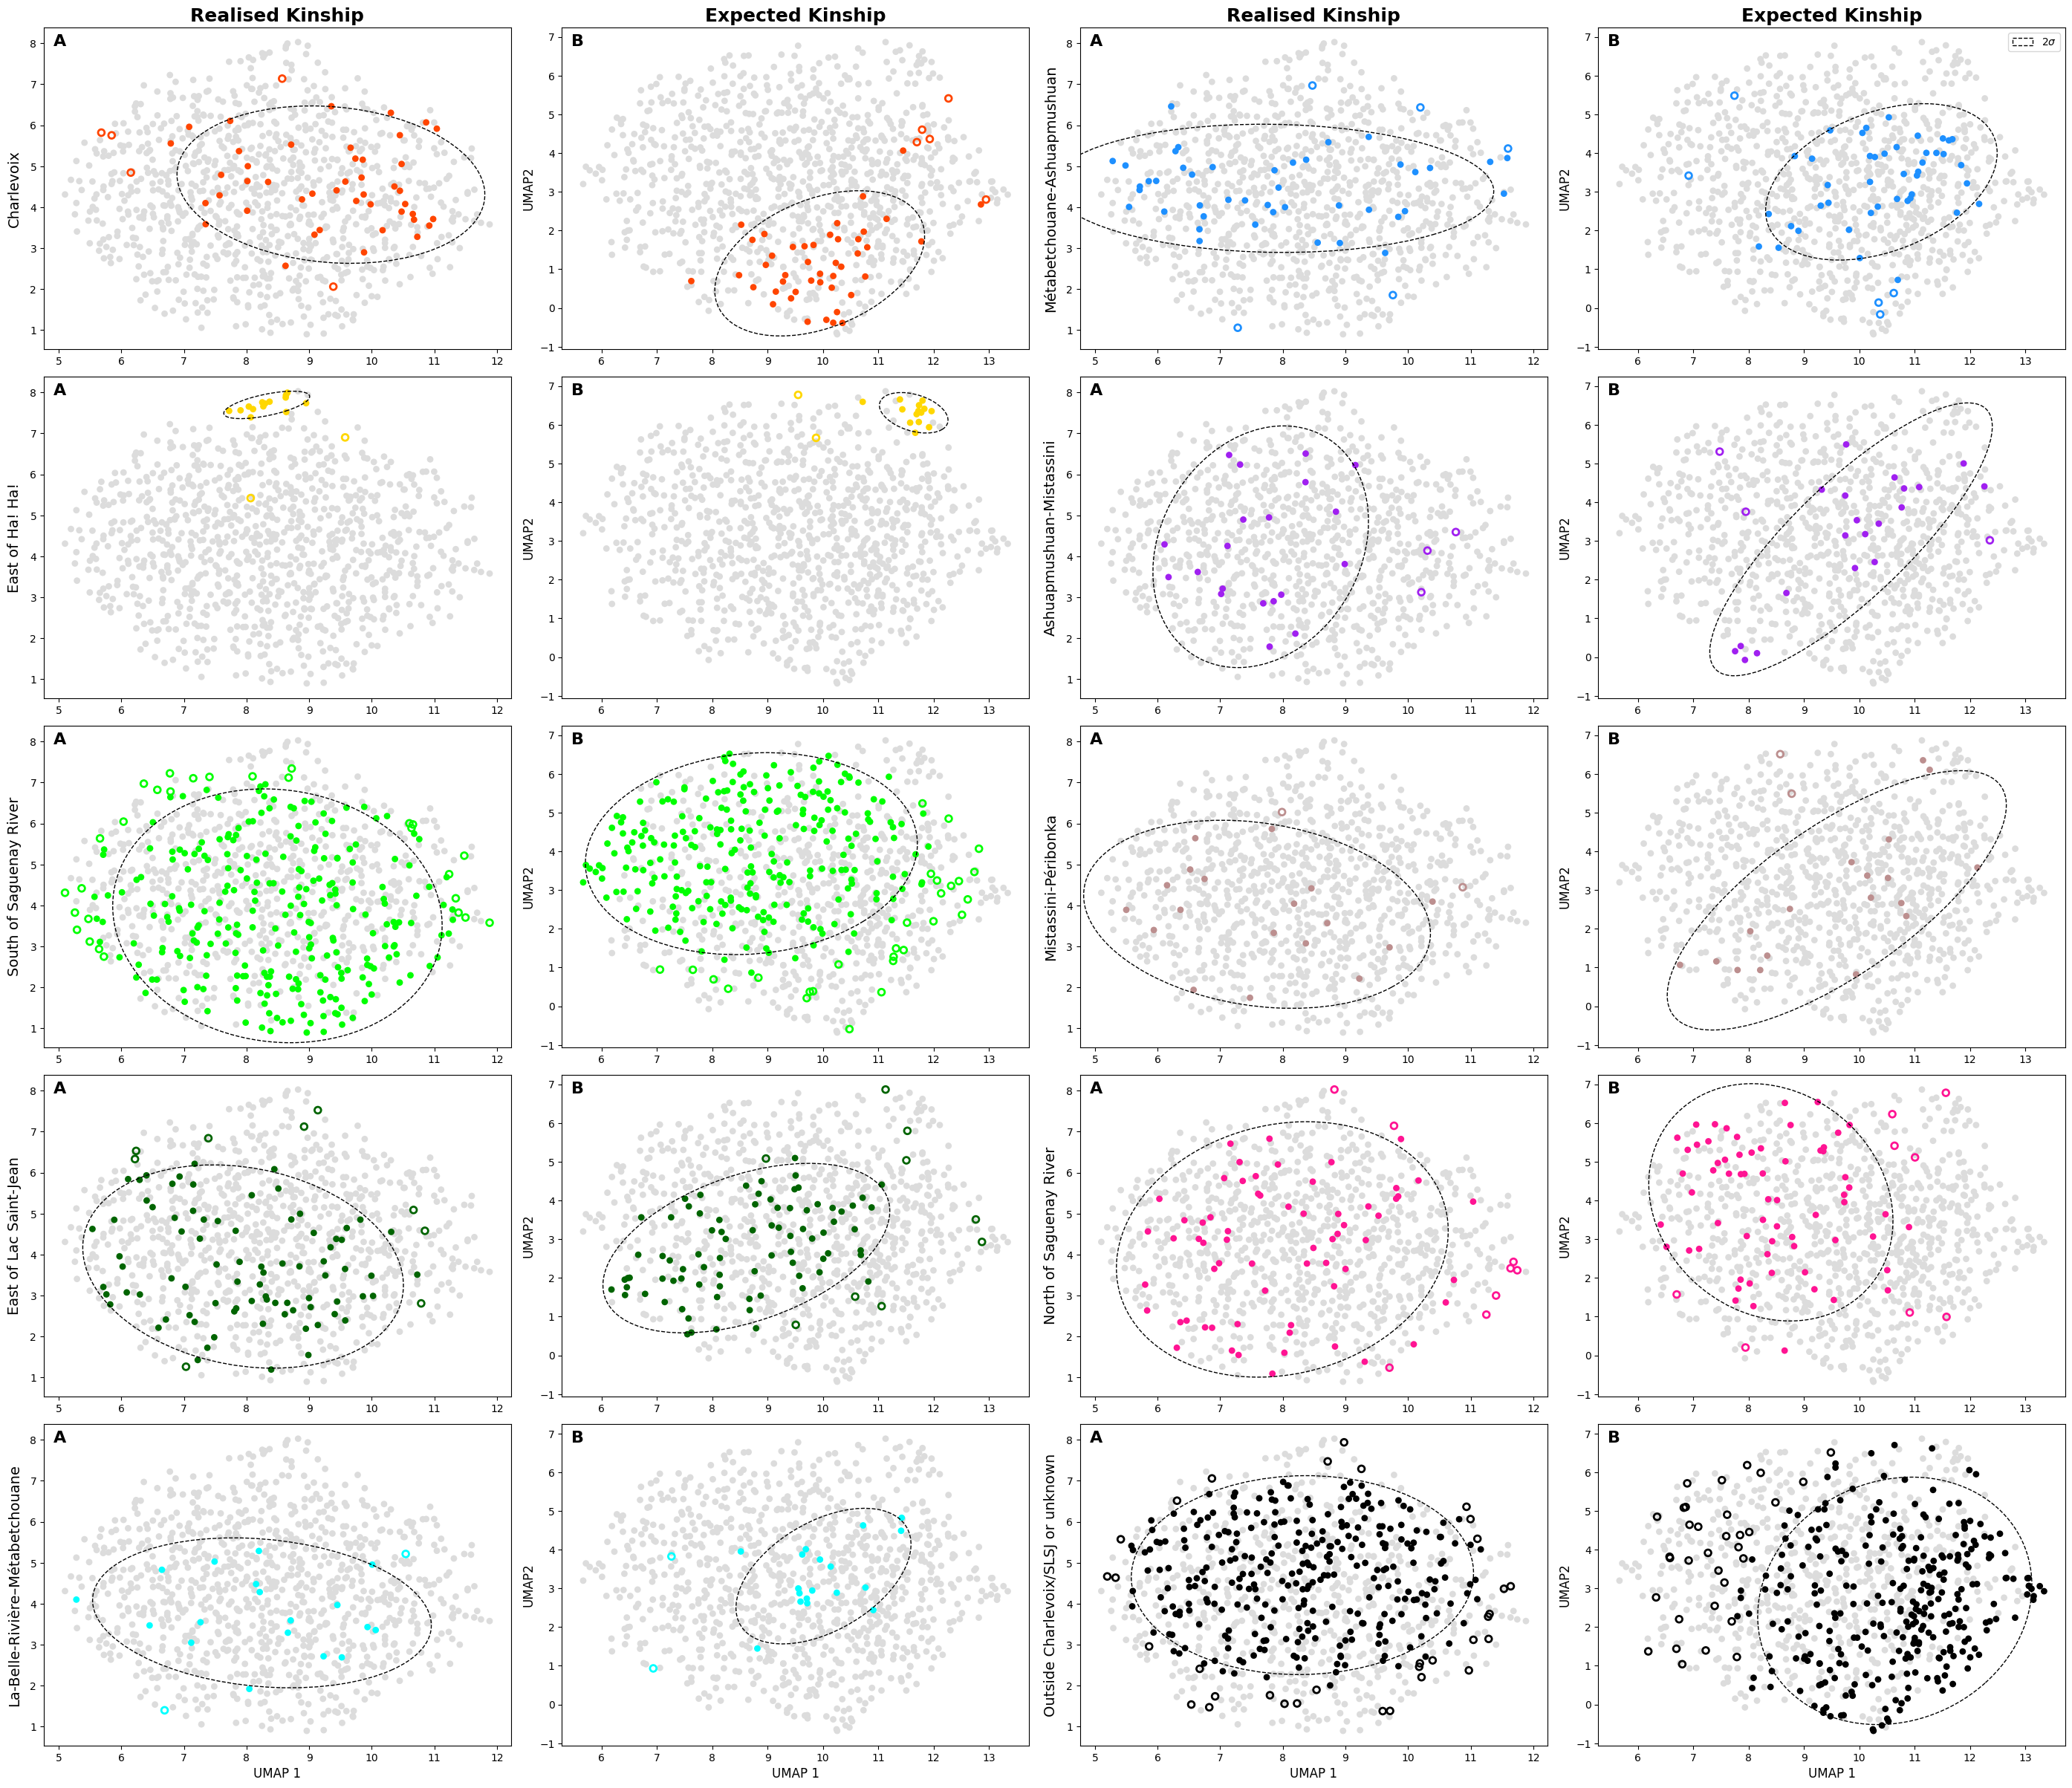

In [23]:
# 1. Define the list of locations in the desired order
locations = [
    "Charlevoix",
    "East of Ha! Ha!",
    "South of Saguenay River",
    "East of Lac Saint-Jean",
    "La-Belle-Rivière–Métabetchouane",
    "Métabetchouane-Ashuapmushuan",
    "Ashuapmushuan-Mistassini",
    "Mistassini-Péribonka",
    "North of Saguenay River",
    "Outside Charlevoix/SLSJ or unknown"
]

subdivision_to_colour["Outside Charlevoix/SLSJ or unknown"] = 'black'

# 2. Create a 5x4 grid of subplots to hold the two halves side-by-side.
#    Adjust figsize for a wider layout.
fig, axes = plt.subplots(5, 4, figsize=(28, 25), dpi=100)

# 3. Add main titles for the columns.
column_titles = ["Realised Kinship", "Expected Kinship", "Realised Kinship", "Expected Kinship"]
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=18, fontweight='bold')

# 4. Loop through each location to plot it in the correct grid position.
for i, location in enumerate(locations):
    # Determine the row and column for the plot pair
    if i < 5:
        # First 5 locations go in the first half (cols 0 & 1)
        row = i
        col_offset = 0
    else:
        # Next 5 locations go in the second half (cols 2 & 3)
        row = i - 5
        col_offset = 2

    # Select the correct axes based on the calculated position
    ax_left = axes[row, col_offset]
    ax_right = axes[row, col_offset + 1]

    # Filter data for the current location
    gray_indices = [index for index, boundary in enumerate(boundaries_parents) if boundary != location]
    filter_indices = [index for index, boundary in enumerate(boundaries_parents) if boundary == location]

    # --- Plot 1: Genetic Data ---
    if filter_indices:
        covariance_genes = EllipticEnvelope().fit_predict(umap_genes_slsj[filter_indices, :])
        xvalues_genes = np.array([x for x, value in zip(umap_genes_slsj[:, 0][filter_indices], covariance_genes) if value == 1])
        yvalues_genes = np.array([y for y, value in zip(umap_genes_slsj[:, 1][filter_indices], covariance_genes) if value == 1])

        sns.scatterplot(x=umap_genes_slsj[:, 0][gray_indices], y=umap_genes_slsj[:, 1][gray_indices], color='gainsboro', edgecolor='none', s=40, ax=ax_left)
        sns.scatterplot(x=xvalues_genes, y=yvalues_genes, color=subdivision_to_colour[location], edgecolor='none', s=40, ax=ax_left)
        sns.scatterplot(x=[x for x, value in zip(umap_genes_slsj[:, 0][filter_indices], covariance_genes) if value == -1], y=[y for y, value in zip(umap_genes_slsj[:, 1][filter_indices], covariance_genes) if value == -1], facecolors='none', edgecolor=subdivision_to_colour[location], linewidth=2, s=40, ax=ax_left)
        
        ax_left.text(0.02, 0.98, "A", transform=ax_left.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
        confidence_ellipse(xvalues_genes, yvalues_genes, ax_left, n_std=2, label=r'$2\sigma$', edgecolor='black', linestyle='--')

    # Set y-label for the left plot as the row title
    ax_left.set_ylabel(location, fontsize=14, rotation=90, labelpad=15, va='center')

    # --- Plot 2: Genealogical Data ---
    if filter_indices:
        covariance_genealogy = EllipticEnvelope().fit_predict(umap_genealogy_slsj[filter_indices, :])
        xvalues_genealogy = np.array([x for x, value in zip(umap_genealogy_slsj[:, 0][filter_indices], covariance_genealogy) if value == 1])
        yvalues_genealogy = np.array([y for y, value in zip(umap_genealogy_slsj[:, 1][filter_indices], covariance_genealogy) if value == 1])

        sns.scatterplot(x=umap_genealogy_slsj[:, 0][gray_indices], y=umap_genealogy_slsj[:, 1][gray_indices], color='gainsboro', edgecolor='none', s=40, ax=ax_right)
        sns.scatterplot(x=xvalues_genealogy, y=yvalues_genealogy, color=subdivision_to_colour[location], edgecolor='none', s=40, ax=ax_right)
        sns.scatterplot(x=[x for x, value in zip(umap_genealogy_slsj[:, 0][filter_indices], covariance_genealogy) if value == -1], y=[y for y, value in zip(umap_genealogy_slsj[:, 1][filter_indices], covariance_genealogy) if value == -1], facecolors='none', linewidth=2, edgecolor=subdivision_to_colour[location], s=40, ax=ax_right)

        ax_right.text(0.02, 0.98, "B", transform=ax_right.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
        confidence_ellipse(xvalues_genealogy, yvalues_genealogy, ax_right, n_std=2, label=r'$2\sigma$', edgecolor='black', linestyle='--')

    # Set y-label for the right plot
    ax_right.set_ylabel('UMAP2', fontsize=12)

# 5. Add legend to the top-right plot of the first pair.
axes[0, 3].legend()

# 6. Set x-axis labels ONLY for the plots on the bottom row.
for r in range(5):
    for c in range(4):
        if r == 4: # Row 4 is the bottom row
            axes[r, c].set_xlabel('UMAP 1', fontsize=12)
        else:
            axes[r, c].set_xlabel('')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Add a bit of space at the top for the column titles
fig.subplots_adjust(top=0.95)

fig.savefig(paths['wd'] + "results/supp_figures/3.CARTaGENESubdivisions.svg", bbox_inches='tight')
subdivision_to_colour["Outside Charlevoix/SLSJ or unknown"] = 'gainsboro'
plt.show()